<a href="https://colab.research.google.com/github/ravelfreeadmin/codebrosncaa25/blob/main/CodeBrosNcaa25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [10]:
from google.colab import drive
drive.mount('ncaa25files')

Mounted at ncaa25files


In [18]:
!mkdir -p ~/.kaggle
!cp /ncaa25files/MyDrive/ncaa25files/.kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions list

In [ ]:
!ls /ncaa25files//MyDrive/ncaa25files/files25/


In [25]:
!mkdir -p /content/kaggle/input/ncaa25
!cp /ncaa25files/MyDrive/ncaa25files/files25/* /content/kaggle/input/ncaa25/

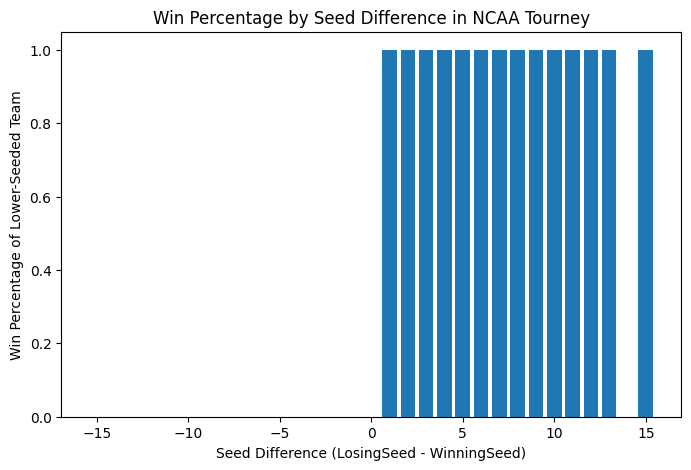

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

# 1) Merge for the winning team
merged_df = pd.merge(
    tourney_results,
    tourney_seeds[['Season', 'TeamID', 'SeedNum']],  # or 'Seed' if you haven't extracted numeric seeds yet
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
)
merged_df.rename(columns={'SeedNum': 'SeedNum_W'}, inplace=True)

# 2) Merge for the losing team
merged_df = pd.merge(
    merged_df,
    tourney_seeds[['Season', 'TeamID', 'SeedNum']],
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
)
merged_df.rename(columns={'SeedNum': 'SeedNum_L'}, inplace=True)

# Now you have 'SeedNum_W' and 'SeedNum_L' columns
merged_df['SeedDiff'] = merged_df['SeedNum_L'] - merged_df['SeedNum_W']

# 5. Group by that difference and compute the fraction of times
#    the lower-seeded team (numerically smaller seed) won.
#    If the game is in the dataset, it means WTeamID actually won. So
#    we just count how often the difference is a particular value, and how often it was positive.
grouped = merged_df.groupby('SeedDiff').agg(
    GamesPlayed=('SeedDiff','count')
).reset_index()

# "WinsByBetterSeed" is the number of games where the difference was > 0 (meaning the better seed won).
# But to get fraction directly for each difference bin, we can do:
# fraction = (# of times WTeam had the better seed) / (# of total games with that difference)
# We'll define a mask for "did the better seed (smaller numeric value) actually win?"
# which is True if "SeedNum_W < SeedNum_L"
merged_df['BetterSeedWon'] = (merged_df['SeedNum_W'] < merged_df['SeedNum_L']).astype(int)

win_pct_df = merged_df.groupby('SeedDiff').agg(
    GamesPlayed=('SeedDiff','count'),
    WinsByBetterSeed=('BetterSeedWon','sum')
).reset_index()

win_pct_df['PctBetterSeedWins'] = win_pct_df['WinsByBetterSeed'] / win_pct_df['GamesPlayed']

# 6. Plot the result
plt.figure(figsize=(8,5))
plt.bar(win_pct_df['SeedDiff'], win_pct_df['PctBetterSeedWins'])
plt.xlabel('Seed Difference (LosingSeed - WinningSeed)')
plt.ylabel('Win Percentage of Lower-Seeded Team')
plt.title('Win Percentage by Seed Difference in NCAA Tourney')
plt.show()
